In [1]:
# %pip install pennylane matplotlib numpy pandas torch torchvision

In [2]:
# Library imports
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pennylane as qml

# Pytorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

from qgenerator import PatchQuantumGenerator

# Set the random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## Temporary Discriminator and Dataset Loader

In [3]:
class DigitsDataset(Dataset):
    """Pytorch dataloader for the Optical Recognition of Handwritten Digits Data Set"""

    def __init__(self, csv_file, label=0, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.csv_file = csv_file
        self.transform = transform
        self.df = self.filter_by_label(label)

    def filter_by_label(self, label):
        # Use pandas to return a dataframe of only zeros
        df = pd.read_csv(self.csv_file)
        df = df.loc[df.iloc[:, -1] == label]
        return df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.df.iloc[idx, :-1] / 16
        image = np.array(image)
        image = image.astype(np.float32).reshape(8, 8)

        if self.transform:
            image = self.transform(image)

        # Return image and label
        return image, 0


In [4]:
image_size = 8  # Height / width of the square images
batch_size = 4

transform = transforms.Compose([transforms.ToTensor()])
dataset = DigitsDataset(csv_file="./optdigits.tra", transform=transform)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, drop_last=True
)


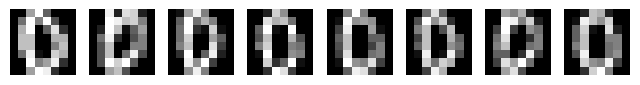

In [5]:
plt.figure(figsize=(8,2))

for i in range(8):
    image = dataset[i][0].reshape(image_size,image_size)
    plt.subplot(1,8,i+1)
    plt.axis('off')
    plt.imshow(image.numpy(), cmap='gray')

plt.show()


In [6]:
class Discriminator(nn.Module):
    """Fully connected classical discriminator"""

    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            # Inputs to first hidden layer (num_input_features -> 64)
            nn.Linear(image_size * image_size, 64),
            nn.ReLU(),
            # First hidden layer (64 -> 16)
            nn.Linear(64, 16),
            nn.ReLU(),
            # Second hidden layer (16 -> output)
            nn.Linear(16, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)


In [7]:
# Quantum variables
n_qubits = 5  # Total number of qubits / N
n_a_qubits = 1  # Number of ancillary qubits / N_A
q_depth = 6  # Depth of the parameterised quantum circuit / D
n_generators = 4  # Number of subgenerators for the patch method / N_G


In [ ]:
lrG = 0.001  # Learning rate for the generator
lrD = 0.0002  # Learning rate for the discriminator
num_iter = 1000  # Number of training iterations
label_smoothing = 0.1  # Label smoothing parameter
grad_clip = 1.0  # Gradient clipping parameter

## Training

In [9]:
# Quantum simulator
dev = qml.device("lightning.qubit", wires=n_qubits)
# Enable CUDA device if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
discriminator = Discriminator().to(device)
generator = PatchQuantumGenerator(n_generators, n_qubits, q_depth, n_a_qubits).to(device)

# Binary cross entropy
criterion = nn.BCELoss()

# Optimisers
optD = optim.Adam(discriminator.parameters(), lr=lrD, betas=(0.5, 0.999))
optG = optim.Adam(generator.parameters(), lr=lrG, betas=(0.5, 0.999))

real_labels = torch.full((batch_size,), 1.0 - label_smoothing, dtype=torch.float, device=device)
fake_labels = torch.full((batch_size,), label_smoothing, dtype=torch.float, device=device)

# Fixed noise allows us to visually track the generated images throughout training
fixed_noise = torch.rand(8, n_qubits, device=device) * math.pi / 2

# Iteration counter
counter = 0

# Collect images for plotting later
results = []

# Track discriminator accuracy to balance training
d_acc_real = 0.0
d_acc_fake = 0.0

while True:
    for i, (data, _) in enumerate(dataloader):

        # Data for training the discriminator
        data = data.reshape(-1, image_size * image_size)
        real_data = data.to(device)
        current_batch_size = real_data.size(0)

        # Adjust labels for current batch size
        real_labels_batch = torch.full((current_batch_size,), 1.0 - label_smoothing, dtype=torch.float, device=device)
        fake_labels_batch = torch.full((current_batch_size,), label_smoothing, dtype=torch.float, device=device)

        # Noise following a uniform distribution in range [0,pi/2)
        noise = torch.rand(current_batch_size, n_qubits, device=device) * math.pi / 2
        fake_data = generator(noise)

        # Training the discriminator
        discriminator.zero_grad()
        outD_real = discriminator(real_data).view(-1)
        outD_fake = discriminator(fake_data.detach()).view(-1)

        errD_real = criterion(outD_real, real_labels_batch)
        errD_fake = criterion(outD_fake, fake_labels_batch)
        
        # Propagate gradients
        errD_real.backward()
        errD_fake.backward()
        
        # Clip discriminator gradients
        torch.nn.utils.clip_grad_norm_(discriminator.parameters(), grad_clip)

        errD = errD_real + errD_fake
        optD.step()

        # Only train generator if discriminator is not too strong
        # Check discriminator accuracy
        d_acc_real = (outD_real > 0.5).float().mean().item()
        d_acc_fake = (outD_fake < 0.5).float().mean().item()
        
        # Train generator (always, but with gradient clipping)
        generator.zero_grad()
        # Generate new fake data for generator training
        noise = torch.rand(current_batch_size, n_qubits, device=device) * math.pi / 2
        fake_data = generator(noise)
        outD_fake = discriminator(fake_data).view(-1)
        
        # Use smoothed labels for generator too
        errG = criterion(outD_fake, real_labels_batch)
        errG.backward()
        
        # Clip generator gradients to prevent explosion
        torch.nn.utils.clip_grad_norm_(generator.parameters(), grad_clip)
        
        optG.step()

        counter += 1

        # Show loss values
        if counter % 10 == 0:
            print(f'Iteration: {counter}, Discriminator Loss: {errD:0.3f}, Generator Loss: {errG:0.3f}, D_Acc_Real: {d_acc_real:0.3f}, D_Acc_Fake: {d_acc_fake:0.3f}')
            test_images = generator(fixed_noise).view(8,1,image_size,image_size).cpu().detach()

            # Save images every 50 iterations
            if counter % 50 == 0:
                results.append(test_images)

        if counter == num_iter:
            break
    if counter == num_iter:
        break


Iteration: 10, Discriminator Loss: 1.358, Generator Loss: 0.613, D_Acc_Real: 1.000, D_Acc_Fake: 0.000
Iteration: 20, Discriminator Loss: 1.333, Generator Loss: 0.619, D_Acc_Real: 1.000, D_Acc_Fake: 0.000
Iteration: 30, Discriminator Loss: 1.290, Generator Loss: 0.638, D_Acc_Real: 1.000, D_Acc_Fake: 0.000
Iteration: 40, Discriminator Loss: 1.277, Generator Loss: 0.665, D_Acc_Real: 1.000, D_Acc_Fake: 0.000
Iteration: 50, Discriminator Loss: 1.234, Generator Loss: 0.675, D_Acc_Real: 1.000, D_Acc_Fake: 0.000
Iteration: 60, Discriminator Loss: 1.206, Generator Loss: 0.684, D_Acc_Real: 1.000, D_Acc_Fake: 0.750
Iteration: 70, Discriminator Loss: 1.182, Generator Loss: 0.714, D_Acc_Real: 1.000, D_Acc_Fake: 0.750
Iteration: 80, Discriminator Loss: 1.154, Generator Loss: 0.725, D_Acc_Real: 1.000, D_Acc_Fake: 1.000
Iteration: 90, Discriminator Loss: 1.089, Generator Loss: 0.737, D_Acc_Real: 1.000, D_Acc_Fake: 1.000
Iteration: 100, Discriminator Loss: 1.076, Generator Loss: 0.763, D_Acc_Real: 1.00

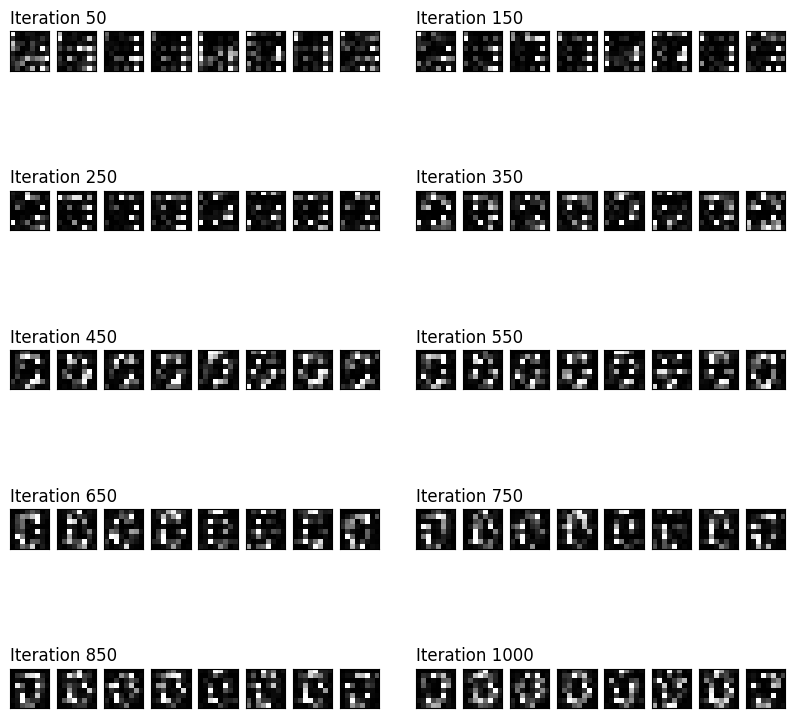

In [12]:
# Always display 10 images at evenly spaced iterations
num_display = 10
if len(results) < num_display:
    display_indices = list(range(len(results)))
else:
    interval = max(1, len(results) // num_display)
    display_indices = [i * interval for i in range(num_display)]
    # Ensure the last index is always included
    if display_indices[-1] != len(results) - 1:
        display_indices[-1] = len(results) - 1

n_cols = 2
n_rows = int(math.ceil(len(display_indices) / n_cols))

fig = plt.figure(figsize=(10, 2 * n_rows))
outer = gridspec.GridSpec(n_rows, n_cols, wspace=0.1)

for plot_idx, res_idx in enumerate(display_indices):
    images = results[res_idx]
    row = plot_idx // n_cols
    col = plot_idx % n_cols
    outer_idx = row * n_cols + col
    if outer_idx >= n_rows * n_cols:
        break  # Prevent index out of range

    inner = gridspec.GridSpecFromSubplotSpec(1, images.size(0),
                    subplot_spec=outer[outer_idx])

    images = torch.squeeze(images, dim=1)
    for j, im in enumerate(images):

        ax = plt.Subplot(fig, inner[j])
        ax.imshow(im.numpy(), cmap="gray")
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            # Calculate the correct iteration
            iter_num = int((res_idx + 1) * (num_iter / len(results)))
            ax.set_title(f'Iteration {iter_num}', loc='left')
        fig.add_subplot(ax)

plt.show()
